# Исследование объявлений о продаже квартир

В распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Загрузка данных и изучение общей информации. 

In [1]:
# Иморт библиотек и загрузка файла, разделитель '\t'.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
try:
    data = pd.read_csv('c:/projects/datasets/real_estate_data.csv', sep='\t')
except:
    print('Попробуйте другие параметры')
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
# Вывод общей информации от таблице.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Гистограммы по всем столбцам датасета


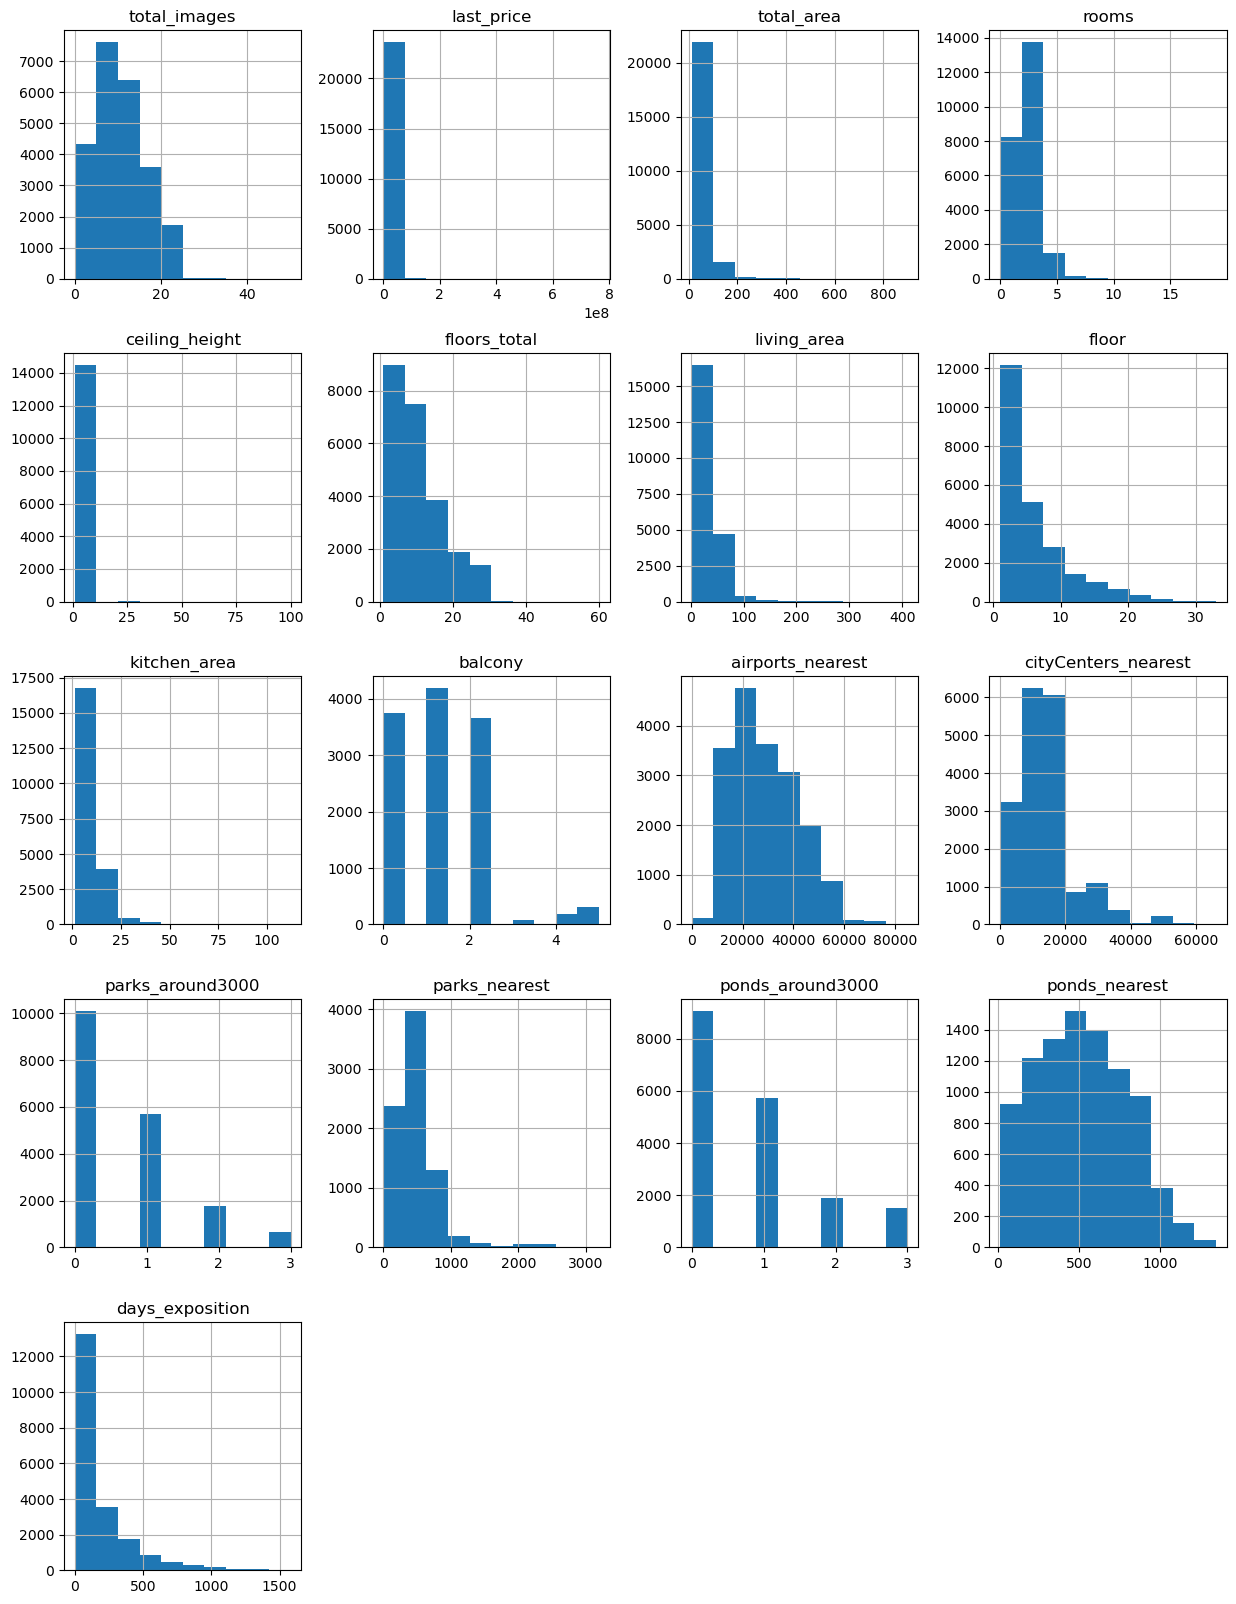

In [3]:
print('Гистограммы по всем столбцам датасета')
data.hist(figsize=(15, 20));

Данные загружены. Переименование столбцов не требется, названия в "змеином" стиле. Гистограммы столбцов `last_price`, `ceiling_height`, `balcony`, `cityCenters_nearest`, `parks_nearest` отличаются от типичных распределений данных (Пуассона, нормальное). Возможно из-за пропусков данных. Столбец с датой first_day_exposition нужно перевести в формат дата.

### Предобработка данных

**Обработка пропусков**

In [4]:
# Находим все пропуски в таблице
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски в столбце `ceiling_height` (высота потолка) заполняем медианным значением для этого столбца.  

In [5]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски в столбце `floors_total` и `locality_name` оставляем, логичную замену предложить не возможно. Можно было бы удалить такие строки, количество их невелико. Но по условию задания удаление не возможно, оставляем пропуски не заполненными, поскольку пропуски - важный сигнал, который нужно учитывать.

Пропуски в столбце `living_area` (жилая площадь) заполняем средним значением жилой площади для этого столбца в зависимости от количества комнат.

In [6]:
for a in data['rooms'].unique():
    data.loc[(data['rooms'] == a) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == a), 'living_area'].mean()
print(data['living_area'].isna().sum())
data.isna().sum()

0


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

По столбцу `is_apartment` (апартаменты) только по 12 % данных внесена информация пользователями. Присутствуют как значения False, так и True. Значений True 50 по выборке из 23698 объектов, 0,21%, что отличается от доли апартаментов по открытым источникам. [Доля апартаментов составляет около 8%](https://www.kommersant.ru/doc/4205125) Значит нельзя предположить, что не заполненные значения - это указание на "не апартаменты" = квартиры. Логичную замену пропускам предложить невозможно, оставляем столбец как есть. Необходимо переговорить с разработчиками / поставщиком данных о причине пропусков и возможности ее устранения.

In [7]:
data['is_apartment'].value_counts()

False    2725
True       50
Name: is_apartment, dtype: int64

Пропуски в столбце `kitchen_area` (площадь кухни) заполняем медианным значением для этого столбца. Со значениями других столбцов площадь кухни не связана, в отличии от столбца жилая площадь.

In [8]:
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area                0
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Для пропусков в столбце `balcony` предположим, что пользователь не указывал это значение, если в квартире нет балкона, 
заполним пропуски нулями. 

In [9]:
data['balcony'] = data['balcony'].fillna(0)
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Пропуски в столбцах `airports_nearest` (5542 шт.) и `cityCenters_nearest` (5519) сильно повлияют на результаты исследования. Пропуски в данных по этим столбцам совпадают, ниже приведена оценка. Число строк, где имеются пропуски в обоих этих столбцах равно 5501. По условию задания строки сохраняем, пропуски оставляем не заполненными.
Необходимо сообщить разработчикам о пропусках в данных. Возможные причины: 
- неправильное определение координат объекта 
- ошибки в алгоритмах определения ближайшего аэропорта / расстояния до центра города
- ошибки выгрузки данных

In [10]:
print(len(data.query(('airports_nearest.isna() == True') and ('cityCenters_nearest.isna() == True'))))

5519


<a id='example'></a>

In [11]:

# Примеры строк для bug-report
display((data.query(('airports_nearest.isna() == True') and ('cityCenters_nearest.isna() == True'))).head(5))

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.65,12.0,14.400000,5,NaN,...,9.10,0.0,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.65,27.0,15.430000,26,NaN,...,8.81,0.0,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
12,10,3890000.0,54.00,2016-06-30T00:00:00,2,2.65,5.0,30.000000,5,NaN,...,9.00,0.0,Сертолово,NaN,NaN,NaN,NaN,NaN,NaN,90.0
22,20,5000000.0,58.00,2017-04-24T00:00:00,2,2.75,25.0,30.000000,15,NaN,...,11.00,2.0,деревня Кудрово,NaN,NaN,NaN,NaN,NaN,NaN,60.0
30,12,2200000.0,32.80,2018-02-19T00:00:00,1,2.65,9.0,17.893552,2,NaN,...,9.10,0.0,Коммунар,NaN,NaN,NaN,NaN,NaN,NaN,63.0


При просмотре строк для отчета разработчикам об ошибках видно, что в этих строках есть пропуски также по столбцам `parks_around3000` и `ponds_around3000`, количество пропусков в которых 5518, похоже на число пропусков в столбцах `airports_nearest` и `cityCenters_nearest`. Ниже подтверждение, что число пропусков практически совпадает.

In [12]:
print(len(data.query(
    ('airports_nearest.isna() == True') and 
    ('cityCenters_nearest.isna() == True') and 
    ('parks_around3000.isna() == True') and
    ('ponds_around3000.isna() == True')
)))

5518


В столбце с пропусками `parks_nearest` судя по его значениям и названию хранится расстояние до ближайшего парка. Значений с расстоянием 0 в столбце нет. Есть также столбец `parks_around3000` с количеством парков в пределах 3000 метров. Проверим, есть ли строки, где в `parks_around3000` указано 1, 2 или 3, а в `parks_nearest` пропуск. Если такие строки есть, заполняем их значением 3000. Все остальные пропуски в `parks_nearest` оставляем не заполненными.

In [13]:
data['parks_nearest'].value_counts()

441.0     67
173.0     41
392.0     41
456.0     40
471.0     32
          ..
3.0        1
2847.0     1
1443.0     1
7.0        1
2984.0     1
Name: parks_nearest, Length: 995, dtype: int64

In [14]:
data['parks_around3000'].value_counts()

0.0    10106
1.0     5681
2.0     1747
3.0      647
Name: parks_around3000, dtype: int64

In [15]:
data.loc[((data['parks_around3000'] == 1) | (data['parks_around3000'] == 2) | (data['parks_around3000'] == 3)) & (data['parks_nearest'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


In [16]:
data.loc[(data['parks_around3000'] == 0) & (data['parks_nearest'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.600000,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
6,6,3700000.0,37.3,2017-11-02T00:00:00,1,2.65,26.0,10.600000,6,NaN,...,14.4,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.6,2019-04-18T00:00:00,2,2.65,24.0,31.736849,22,NaN,...,18.9,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
9,18,5400000.0,61.0,2017-02-26T00:00:00,3,2.50,9.0,43.600000,7,NaN,...,6.5,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0
11,9,3300000.0,44.0,2018-08-27T00:00:00,2,2.65,5.0,31.000000,4,False,...,6.0,1.0,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23684,20,21400000.0,145.0,2018-11-02T00:00:00,4,3.00,26.0,71.400000,17,NaN,...,15.6,0.0,Санкт-Петербург,11827.0,11459.0,0.0,NaN,0.0,NaN,NaN
23685,15,2490000.0,31.0,2019-01-24T00:00:00,1,2.50,5.0,17.300000,5,NaN,...,5.6,1.0,Ломоносов,48393.0,51818.0,0.0,NaN,0.0,NaN,NaN
23687,6,3200000.0,39.0,2017-12-16T00:00:00,1,2.65,9.0,20.000000,6,NaN,...,11.0,2.0,Санкт-Петербург,40837.0,16704.0,0.0,NaN,0.0,NaN,38.0
23688,19,9200000.0,101.0,2019-04-01T00:00:00,3,3.05,15.0,63.000000,12,NaN,...,15.0,0.0,Санкт-Петербург,15632.0,14428.0,0.0,NaN,0.0,NaN,23.0


Аналогично пытаемся убрать пропуски в `ponds_nearest`.

In [17]:
data['ponds_nearest'].value_counts()

427.0     70
454.0     41
153.0     40
433.0     39
474.0     37
          ..
150.0      1
967.0      1
131.0      1
1164.0     1
1134.0     1
Name: ponds_nearest, Length: 1096, dtype: int64

In [18]:
data['ponds_around3000'].value_counts()

0.0    9071
1.0    5717
2.0    1892
3.0    1501
Name: ponds_around3000, dtype: int64

In [19]:
# Проверяем есть ли пропуски в 'ponds_nearest', куда можно подставить значение из 'ponds_around3000'
data.loc[((data['ponds_nearest'] == 1) | (data['ponds_nearest'] == 2) | (data['ponds_nearest'] == 3)) & (data['ponds_nearest'].isna())]

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition


Пропуски в столбце `days_exposition` оставляем, т.к. не заметна связь с другими столбцами и не понятно каким характерным
значением можно заполнить пропуски.

In [20]:
data.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

**Преобразование типов данных**
Столбец `first_day_exposition` необходимо перевести в тип данных `datetame`, чтобы работать с временем и датой, например исследовать статистику по дням, месяцам и годам.
Столбцы `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000`, `days_exposition` лучше перевести в тип данных `int64` для экономии вычислительных ресурсов, если это позволят сделать оставленные пропуски. 

In [21]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y.%m.%d %H:%M:%S')
data['floors_total'] = data['floors_total'].astype('int', errors='ignore')
data['balcony'] = data['balcony'].astype('int', errors='ignore')
data['parks_around3000'] = data['parks_around3000'].astype('int', errors='ignore')
data['ponds_around3000'] = data['ponds_around3000'].astype('int', errors='ignore')
data['days_exposition'] = data['days_exposition'].astype('int', errors='ignore')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          2775 non-null   object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

**Поиск дубликатов**
- Изучаем, есть ли повторяющиеся строки в датасете
- Изучаем уникальные значения в столбце с названиями локаций. Меняем `посёлок` на `поселок`, а также некоторые значения, связанные с пропуском названия населенного пункта.

In [22]:
# Поиск полностью совпадающих строк в датасете.
data.duplicated().sum()

0

In [23]:
# Уникальные значения столбца с названиями локаций
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [24]:
# Замена 'посёлок' на 'поселок'
data['locality_name'] = data['locality_name'].replace('посёлок', 'поселок', regex=True)
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет

In [25]:
# замена Мурино и Кудрино
data['locality_name'] = data['locality_name'].replace(['Мурино', 'Кудрово'], ['поселок Мурино', 'деревня Кудрово'])
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'городской поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'поселок Металлострой',
       'поселок городского типа Лебяжье',
       'поселок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок городского типа Ефимовский', 'поселок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет

**Обработка аномальных значений**
- В столбце `ceiling_height` присутствуют аномально большие значения высоты потолка. Предположим, что в жилом помещении не может быть потолок выше 6 метров (2 этажа). Высота от 6 до 22,6 метров включительно аномальная, не понятно, какими значениями можно заполнить. Высота от 24 до 32 предположительно на самом деле от 2,4 до 3,2 метров. Значение высоты потолка 100 метров аномально и не понятно как заполнить.
- В столбце `living_area` большие значения соответствуют квартирам с большим количеством комнат (столбец `rooms`), соответственно это не аномалии. Значения с очень малыми значениями жилой площади менее 5 метров заполняем разницей между общей площадью и площадью кухни.
- Изучены значения в столбце `kitchen_area` менее 3 и более 70 метров. Они соответствуют квартирам с небольшой и с большой площадью, соответственно. Данные выглядят естественно и не похожи на аномалии.

В других столбцах аномалии не обнаружены.

In [26]:
# Уникальные значения столбца ceiling_height отсортированные по возрастанию
a = data['ceiling_height'].unique()
a.sort()
a

array([  1.  ,   1.2 ,   1.75,   2.  ,   2.2 ,   2.25,   2.3 ,   2.34,
         2.4 ,   2.45,   2.46,   2.47,   2.48,   2.49,   2.5 ,   2.51,
         2.52,   2.53,   2.54,   2.55,   2.56,   2.57,   2.58,   2.59,
         2.6 ,   2.61,   2.62,   2.63,   2.64,   2.65,   2.66,   2.67,
         2.68,   2.69,   2.7 ,   2.71,   2.72,   2.73,   2.74,   2.75,
         2.76,   2.77,   2.78,   2.79,   2.8 ,   2.81,   2.82,   2.83,
         2.84,   2.85,   2.86,   2.87,   2.88,   2.89,   2.9 ,   2.91,
         2.92,   2.93,   2.94,   2.95,   2.96,   2.97,   2.98,   2.99,
         3.  ,   3.01,   3.02,   3.03,   3.04,   3.05,   3.06,   3.07,
         3.08,   3.09,   3.1 ,   3.11,   3.12,   3.13,   3.14,   3.15,
         3.16,   3.17,   3.18,   3.2 ,   3.21,   3.22,   3.23,   3.24,
         3.25,   3.26,   3.27,   3.28,   3.29,   3.3 ,   3.31,   3.32,
         3.33,   3.34,   3.35,   3.36,   3.37,   3.38,   3.39,   3.4 ,
         3.42,   3.43,   3.44,   3.45,   3.46,   3.47,   3.48,   3.49,
      

In [27]:
# Исключаем строки с высотой потолков 100 метров
data = data[data['ceiling_height']<100]
a = data['ceiling_height'].unique()
a.sort()
a

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.3 ,  2.34,  2.4 ,
        2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,  2.53,
        2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,  2.62,
        2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,  2.71,
        2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,  2.8 ,
        2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,  2.89,
        2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,  2.98,
        2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,  3.07,
        3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,  3.16,
        3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,  3.26,
        3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,  3.33,  3.34,  3.35,
        3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,  3.43,  3.44,  3.45,
        3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,  3.54,
        3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,  3.62,  3.63,  3.65,
        3.66,  3.67,

In [28]:
# исключаем строки с высотой потолков от 6 до 22,6 метров
data = data[(data['ceiling_height'] < 6) | (data['ceiling_height'] > 22.6)]
a = data['ceiling_height'].unique()
a.sort()
a

array([ 1.  ,  1.2 ,  1.75,  2.  ,  2.2 ,  2.25,  2.3 ,  2.34,  2.4 ,
        2.45,  2.46,  2.47,  2.48,  2.49,  2.5 ,  2.51,  2.52,  2.53,
        2.54,  2.55,  2.56,  2.57,  2.58,  2.59,  2.6 ,  2.61,  2.62,
        2.63,  2.64,  2.65,  2.66,  2.67,  2.68,  2.69,  2.7 ,  2.71,
        2.72,  2.73,  2.74,  2.75,  2.76,  2.77,  2.78,  2.79,  2.8 ,
        2.81,  2.82,  2.83,  2.84,  2.85,  2.86,  2.87,  2.88,  2.89,
        2.9 ,  2.91,  2.92,  2.93,  2.94,  2.95,  2.96,  2.97,  2.98,
        2.99,  3.  ,  3.01,  3.02,  3.03,  3.04,  3.05,  3.06,  3.07,
        3.08,  3.09,  3.1 ,  3.11,  3.12,  3.13,  3.14,  3.15,  3.16,
        3.17,  3.18,  3.2 ,  3.21,  3.22,  3.23,  3.24,  3.25,  3.26,
        3.27,  3.28,  3.29,  3.3 ,  3.31,  3.32,  3.33,  3.34,  3.35,
        3.36,  3.37,  3.38,  3.39,  3.4 ,  3.42,  3.43,  3.44,  3.45,
        3.46,  3.47,  3.48,  3.49,  3.5 ,  3.51,  3.52,  3.53,  3.54,
        3.55,  3.56,  3.57,  3.58,  3.59,  3.6 ,  3.62,  3.63,  3.65,
        3.66,  3.67,

In [29]:
# Потолки более 24 метров делим на 10
data.loc[(data['ceiling_height'] >= 24), 'ceiling_height'] = data['ceiling_height'] / 10
a = data['ceiling_height'].unique()
a.sort()
a

array([1.  , 1.2 , 1.75, 2.  , 2.2 , 2.25, 2.3 , 2.34, 2.4 , 2.45, 2.46,
       2.47, 2.48, 2.49, 2.5 , 2.51, 2.52, 2.53, 2.54, 2.55, 2.56, 2.57,
       2.58, 2.59, 2.6 , 2.61, 2.62, 2.63, 2.64, 2.65, 2.66, 2.67, 2.68,
       2.69, 2.7 , 2.71, 2.72, 2.73, 2.74, 2.75, 2.76, 2.77, 2.78, 2.79,
       2.8 , 2.81, 2.82, 2.83, 2.84, 2.85, 2.86, 2.87, 2.88, 2.89, 2.9 ,
       2.91, 2.92, 2.93, 2.94, 2.95, 2.96, 2.97, 2.98, 2.99, 3.  , 3.01,
       3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1 , 3.11, 3.12,
       3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.2 , 3.21, 3.22, 3.23, 3.24,
       3.25, 3.26, 3.27, 3.28, 3.29, 3.3 , 3.31, 3.32, 3.33, 3.34, 3.35,
       3.36, 3.37, 3.38, 3.39, 3.4 , 3.42, 3.43, 3.44, 3.45, 3.46, 3.47,
       3.48, 3.49, 3.5 , 3.51, 3.52, 3.53, 3.54, 3.55, 3.56, 3.57, 3.58,
       3.59, 3.6 , 3.62, 3.63, 3.65, 3.66, 3.67, 3.68, 3.69, 3.7 , 3.75,
       3.76, 3.78, 3.8 , 3.82, 3.83, 3.84, 3.85, 3.86, 3.87, 3.88, 3.9 ,
       3.93, 3.95, 3.98, 4.  , 4.06, 4.1 , 4.14, 4.

In [30]:
# Жилплощадь более 300 метров
display(data[data['living_area'] > 300])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
660,3,49950000.0,483.9,2017-10-04,7,3.20,6.0,312.5,4,NaN,...,26.4,0,Санкт-Петербург,23079.0,945.0,3.0,461.0,3.0,22.0,391.0
4237,1,50000000.0,517.0,2017-10-14,7,2.65,4.0,332.0,3,NaN,...,22.0,0,Санкт-Петербург,22835.0,1847.0,2.0,477.0,2.0,540.0,NaN
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.0,3,NaN,...,100.0,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
8018,20,84000000.0,507.0,2015-12-17,5,4.45,7.0,301.5,7,True,...,45.5,1,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,1078.0
12401,20,91500000.0,495.0,2017-06-19,7,4.65,7.0,347.5,7,NaN,...,25.0,0,Санкт-Петербург,NaN,5735.0,2.0,110.0,0.0,NaN,14.0
12859,20,140000000.0,631.2,2019-04-09,7,3.90,4.0,322.3,4,NaN,...,19.5,1,Санкт-Петербург,25707.0,4972.0,0.0,NaN,2.0,210.0,NaN
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.7,25,NaN,...,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


In [31]:
a = data['living_area'].unique()
a.sort()
a

array([  2. ,   3. ,   5. , ..., 347.5, 409. , 409.7])

In [32]:
# Строки с жилплощадью менее 5 метров
display(data[data['living_area'] < 5])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
3242,7,4440000.0,41.0,2017-07-02,1,2.65,17.0,3.0,17,NaN,...,11.0,0,Санкт-Петербург,19272.0,13073.0,0.0,NaN,0.0,NaN,216.0
13915,20,6350000.0,52.0,2018-02-06,2,3.00,6.0,2.0,2,NaN,...,9.0,0,Санкт-Петербург,32453.0,6521.0,0.0,NaN,1.0,1012.0,91.0
21758,0,2330000.0,23.0,2018-01-01,0,2.65,24.0,2.0,22,NaN,...,9.1,0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,66.0
23574,14,64990000.0,139.0,2015-11-24,3,3.00,8.0,3.0,8,NaN,...,16.0,1,Санкт-Петербург,33255.0,5975.0,1.0,630.0,3.0,100.0,280.0


In [33]:
# Жилплощадь менее 5 метров заменяем на разницу между общей площадью и кухней
data.loc[(data['living_area'] < 5), 'living_area'] = data['total_area'] - data['kitchen_area']
a = data['living_area'].unique()
a.sort()
a

array([  5. ,   5.4,   6. , ..., 347.5, 409. , 409.7])

In [34]:
a = data['kitchen_area'].unique()
a.sort()
a

array([  1.3 ,   2.  ,   2.3 ,   2.4 ,   2.89,   3.  ,   3.2 ,   3.3 ,
         3.4 ,   3.5 ,   3.7 ,   3.8 ,   4.  ,   4.1 ,   4.2 ,   4.3 ,
         4.4 ,   4.5 ,   4.6 ,   4.7 ,   4.8 ,   4.9 ,   5.  ,   5.04,
         5.06,   5.1 ,   5.14,   5.2 ,   5.21,   5.23,   5.25,   5.28,
         5.29,   5.3 ,   5.31,   5.33,   5.35,   5.4 ,   5.42,   5.44,
         5.47,   5.49,   5.5 ,   5.53,   5.59,   5.6 ,   5.61,   5.62,
         5.64,   5.65,   5.68,   5.7 ,   5.74,   5.75,   5.78,   5.8 ,
         5.82,   5.85,   5.86,   5.9 ,   5.91,   6.  ,   6.02,   6.03,
         6.1 ,   6.16,   6.19,   6.2 ,   6.22,   6.23,   6.24,   6.25,
         6.26,   6.27,   6.28,   6.3 ,   6.31,   6.33,   6.35,   6.36,
         6.37,   6.4 ,   6.47,   6.5 ,   6.55,   6.58,   6.6 ,   6.61,
         6.62,   6.65,   6.7 ,   6.72,   6.73,   6.76,   6.77,   6.8 ,
         6.82,   6.83,   6.84,   6.86,   6.9 ,   6.91,   6.93,   6.95,
         7.  ,   7.02,   7.03,   7.06,   7.09,   7.1 ,   7.12,   7.15,
      

In [35]:
# Строки с кухней меньше 3 метров.
display(data[data['kitchen_area'] < 3])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
906,15,2600000.0,27.00,2017-07-10,1,2.75,23.0,18.0,18,NaN,...,2.00,0,Санкт-Петербург,22131.0,17459.0,0.0,NaN,1.0,411.0,10.0
6262,9,3100000.0,24.00,2018-06-25,2,3.00,5.0,16.0,5,NaN,...,2.00,0,Санкт-Петербург,31960.0,4914.0,2.0,426.0,1.0,936.0,54.0
7950,3,5967734.0,66.40,2017-02-07,2,2.65,4.0,44.4,2,False,...,2.89,0,Санкт-Петербург,44870.0,20802.0,0.0,NaN,0.0,NaN,335.0
8729,9,2200000.0,18.40,2018-08-20,1,2.52,3.0,14.0,3,NaN,...,2.40,0,Пушкин,20710.0,30687.0,0.0,NaN,1.0,155.0,59.0
9138,17,2920000.0,23.29,2018-12-12,1,2.65,3.0,21.0,1,NaN,...,2.00,0,Санкт-Петербург,19506.0,4008.0,0.0,NaN,2.0,45.0,107.0
11033,6,5350000.0,32.00,2016-04-20,1,2.65,14.0,16.0,10,NaN,...,2.00,0,Санкт-Петербург,19008.0,3953.0,0.0,NaN,1.0,69.0,210.0
16367,2,2720000.0,25.70,2017-10-30,1,2.65,19.0,22.6,11,NaN,...,2.00,0,Санкт-Петербург,14472.0,13268.0,0.0,NaN,0.0,NaN,109.0
17834,5,2940000.0,34.70,2017-10-09,1,2.65,26.0,15.5,14,NaN,...,2.30,1,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,318.0
19642,5,1190000.0,14.00,2018-07-29,1,2.65,5.0,11.0,1,NaN,...,2.00,0,Санкт-Петербург,9898.0,11122.0,0.0,NaN,0.0,NaN,4.0
20217,7,4250000.0,28.50,2019-05-01,1,2.80,14.0,19.5,10,NaN,...,1.30,0,Санкт-Петербург,37199.0,12721.0,0.0,NaN,0.0,NaN,NaN


In [36]:
# Строки с кухней больше 50 метров
display(data[data['kitchen_area'] > 70])

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
492,18,95000000.0,216.0,2017-12-05,4,3.00,5.0,86.0,4,NaN,...,77.0,0,Санкт-Петербург,21740.0,436.0,2.0,138.0,3.0,620.0,14.0
2489,9,12500000.0,255.0,2017-04-21,3,2.65,2.0,153.9,2,NaN,...,100.7,0,Санкт-Петербург,29544.0,6916.0,0.0,NaN,3.0,198.0,102.0
4394,20,57000000.0,174.0,2015-11-09,3,3.20,10.0,95.0,6,NaN,...,77.0,0,Санкт-Петербург,31706.0,4166.0,1.0,193.0,3.0,199.0,1039.0
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6.0,409.0,3,NaN,...,100.0,0,Санкт-Петербург,24447.0,4666.0,1.0,767.0,0.0,NaN,14.0
10867,1,56844500.0,177.9,2015-01-15,3,2.65,6.0,87.2,5,True,...,87.2,0,Санкт-Петербург,21860.0,318.0,2.0,160.0,3.0,569.0,NaN
14644,17,47000000.0,150.0,2017-02-28,4,3.70,6.0,58.0,5,NaN,...,75.0,1,Санкт-Петербург,16085.0,7616.0,0.0,NaN,0.0,NaN,507.0
16239,5,82400000.0,181.1,2017-05-24,3,3.90,9.0,58.2,4,False,...,93.2,0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,501.0
16647,15,122000000.0,145.0,2017-04-25,3,3.30,6.0,36.0,2,NaN,...,72.0,0,Санкт-Петербург,33931.0,7023.0,2.0,478.0,3.0,250.0,335.0
16797,9,65850000.0,146.0,2017-07-14,2,2.65,9.0,40.0,3,NaN,...,93.0,0,Санкт-Петербург,25525.0,5845.0,2.0,116.0,0.0,NaN,77.0
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25.0,409.7,25,NaN,...,112.0,0,Санкт-Петербург,30706.0,7877.0,0.0,NaN,2.0,318.0,106.0


### Добавление в таблицу новых столбцов

In [37]:
# Добавление столбца с ценой квадратного метра
data['sq_meter_cost'] = data['last_price'] / data['total_area']
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,NaN,...,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,NaN,...,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,NaN,...,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,47.387941,9,NaN,...,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,NaN,...,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000


In [38]:
# Добавление столбца с датой недели публикации объявления
data['day_first_exposition'] = data['first_day_exposition'].dt.weekday
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,day_first_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,NaN,...,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,NaN,...,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,NaN,...,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,47.387941,9,NaN,...,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,NaN,...,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1


In [39]:
# Добавление столбца с месяцем публикации объявления
data['month_first_exposition'] = data['first_day_exposition'].dt.month
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,day_first_exposition,month_first_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,NaN,...,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,NaN,...,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,NaN,...,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,47.387941,9,NaN,...,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,NaN,...,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6


In [40]:
# Добавление столбца с годом публикации объявления
data['year_first_exposition'] = data['first_day_exposition'].dt.year
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,day_first_exposition,month_first_exposition,year_first_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,NaN,...,16028.0,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,NaN,...,18603.0,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,NaN,...,13933.0,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,47.387941,9,NaN,...,6800.0,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,NaN,...,8098.0,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018


In [41]:
# Создание столбца с типом этажа
data['floor_type'] = 'другой'
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,day_first_exposition,month_first_exposition,year_first_exposition,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,NaN,...,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,NaN,...,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,другой
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,NaN,...,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,47.387941,9,NaN,...,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,NaN,...,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой


In [42]:
# указываем последние этажи
data.loc[(data['floor'] == data['floors_total']), 'floor_type'] = 'последний'
# указываем первые этажи
data.loc[(data['floor'] == 1), 'floor_type'] = 'первый'
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,day_first_exposition,month_first_exposition,year_first_exposition,floor_type
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,NaN,...,1.0,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,NaN,...,0.0,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,NaN,...,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,47.387941,9,NaN,...,2.0,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,NaN,...,2.0,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой


In [43]:
# Расстояние до центра города, округленное до целых значений
data['cityCenters_nearest_km'] = data['cityCenters_nearest'] / 1000
data['cityCenters_nearest_km'] = data['cityCenters_nearest_km'].round()
data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,sq_meter_cost,day_first_exposition,month_first_exposition,year_first_exposition,floor_type,cityCenters_nearest_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.000000,8,NaN,...,482.0,2.0,755.0,NaN,120370.370370,3,3,2019,другой,16.0
1,7,3350000.0,40.4,2018-12-04,1,2.65,11.0,18.600000,1,NaN,...,NaN,0.0,NaN,81.0,82920.792079,1,12,2018,первый,19.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.300000,4,NaN,...,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,47.387941,9,NaN,...,84.0,3.0,234.0,424.0,408176.100629,4,7,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.000000,13,NaN,...,112.0,1.0,48.0,121.0,100000.000000,1,6,2018,другой,8.0


### Исследовательский анализ данных

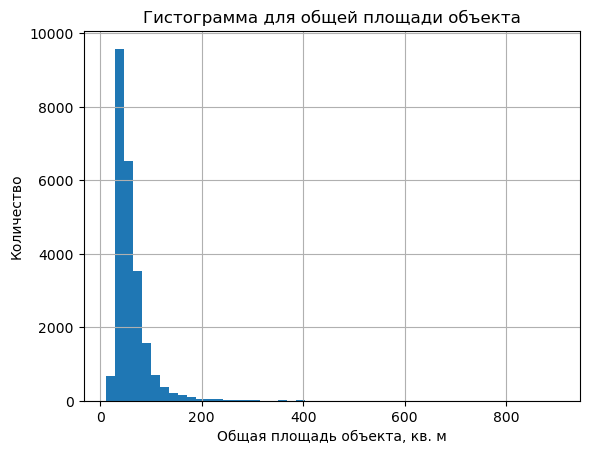

In [44]:
# Гистограмма для общей площади объекта
data['total_area'].hist(bins=50)
plt.title('Гистограмма для общей площади объекта')
plt.xlabel('Общая площадь объекта, кв. м')
plt.ylabel('Количество');

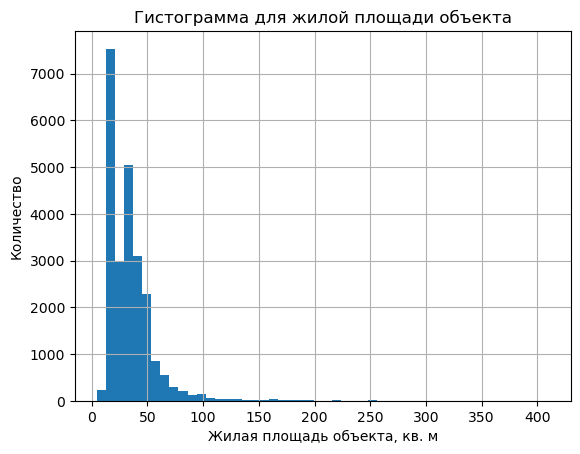

In [45]:
# Гистограмма для жилой площади
data['living_area'].hist(bins=50)
plt.title('Гистограмма для жилой площади объекта')
plt.xlabel('Жилая площадь объекта, кв. м')
plt.ylabel('Количество');

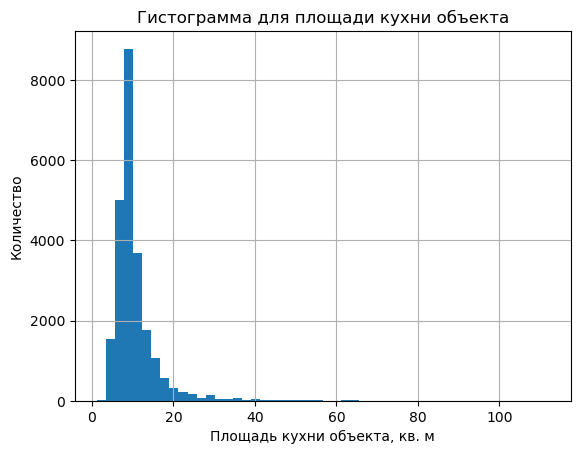

In [46]:
# Гистограмма для площади кухни
data['kitchen_area'].hist(bins=50)
plt.title('Гистограмма для площади кухни объекта')
plt.xlabel('Площадь кухни объекта, кв. м')
plt.ylabel('Количество');

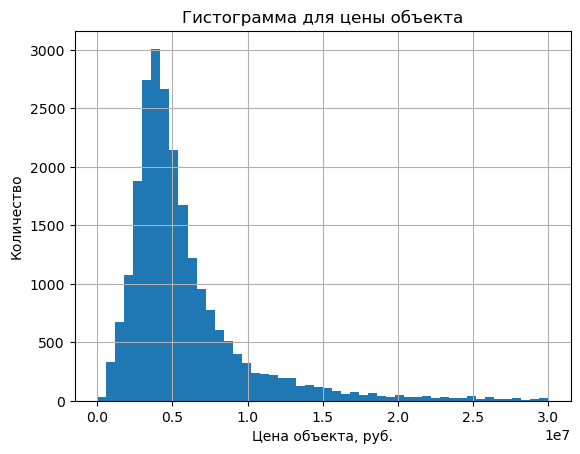

In [47]:
# Гистограмма цены объекта
data['last_price'].hist(bins=50, range=(0, 30000000))
plt.title('Гистограмма для цены объекта')
plt.xlabel('Цена объекта, руб.')
plt.ylabel('Количество');

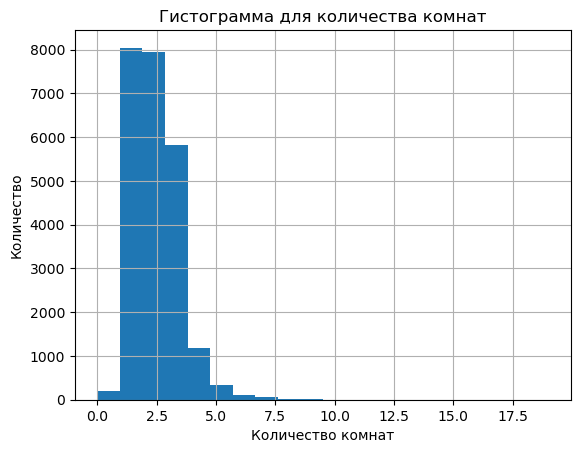

In [48]:
# Гистограмма количества комнат
data['rooms'].hist(bins=20)
plt.title('Гистограмма для количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Количество');

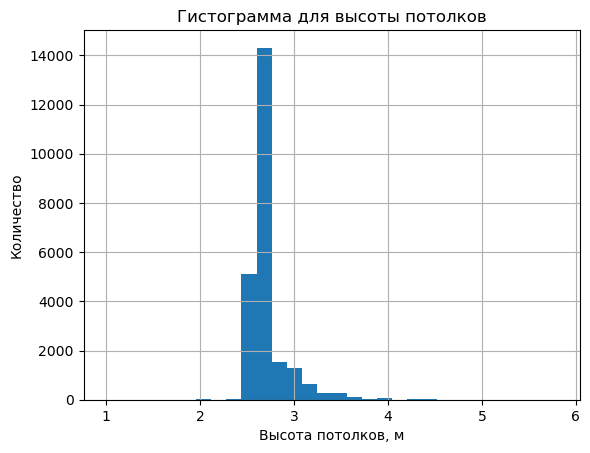

In [49]:
# Гистограмма высота потолков
data['ceiling_height'].hist(bins=30)
plt.title('Гистограмма для высоты потолков')
plt.xlabel('Высота потолков, м')
plt.ylabel('Количество');

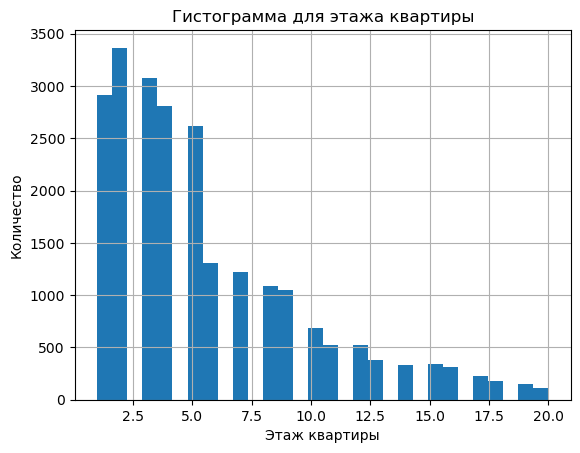

In [50]:
# Гистограмма этаж квартиры
data['floor'].hist(bins=30, range=(1, 20))
plt.title('Гистограмма для этажа квартиры')
plt.xlabel('Этаж квартиры')
plt.ylabel('Количество');

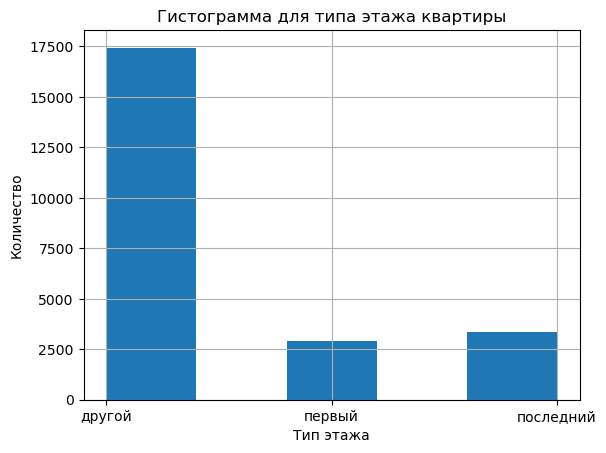

In [51]:
# Гистограмма тип этажа квартиры
data['floor_type'].hist(bins=5)
plt.title('Гистограмма для типа этажа квартиры')
plt.xlabel('Тип этажа')
plt.ylabel('Количество');

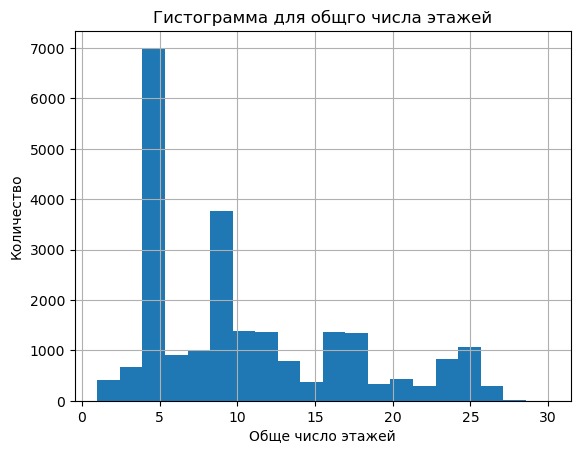

In [52]:
# Гистограмма общее число этажей в доме
data['floors_total'].hist(bins=20, range=(1, 30))
plt.title('Гистограмма для общго числа этажей')
plt.xlabel('Обще число этажей')
plt.ylabel('Количество');

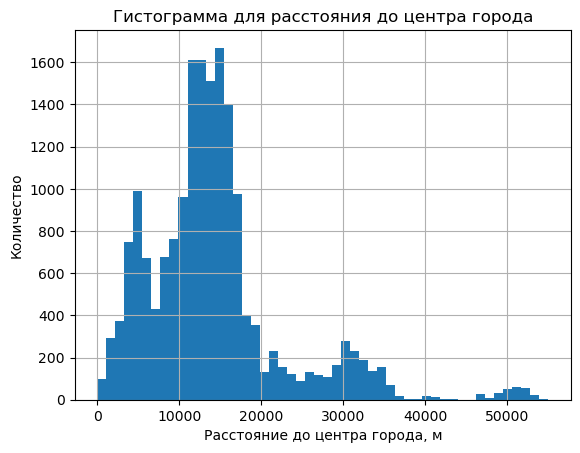

In [53]:
# Гистограмма расстояния до цента города в метрах
data['cityCenters_nearest'].hist(bins=50, range=(0,55000))
plt.title('Гистограмма для расстояния до центра города')
plt.xlabel('Расстояние до центра города, м')
plt.ylabel('Количество');

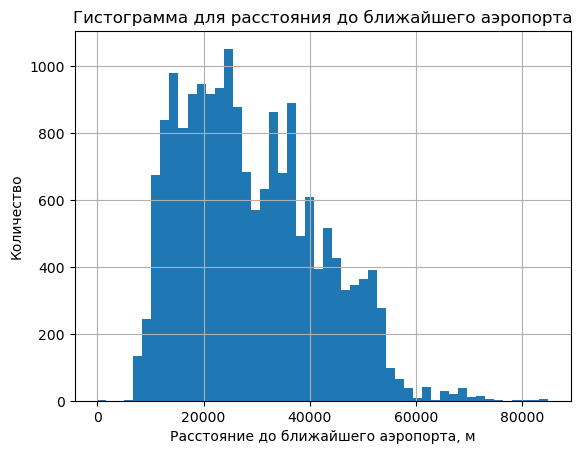

In [54]:
# Гистограмма расстояние до ближайшего аэропорта
data['airports_nearest'].hist(bins=50)
plt.title('Гистограмма для расстояния до ближайшего аэропорта')
plt.xlabel('Расстояние до ближайшего аэропорта, м')
plt.ylabel('Количество');

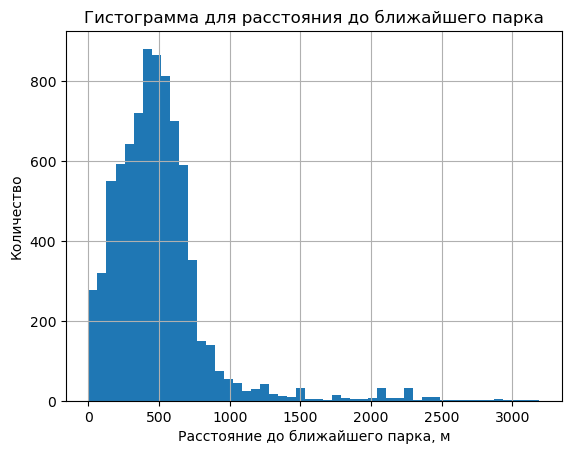

In [55]:
# Гистограмма расстояние до ближайшего парка
data['parks_nearest'].hist(bins=50)
plt.title('Гистограмма для расстояния до ближайшего парка')
plt.xlabel('Расстояние до ближайшего парка, м')
plt.ylabel('Количество');

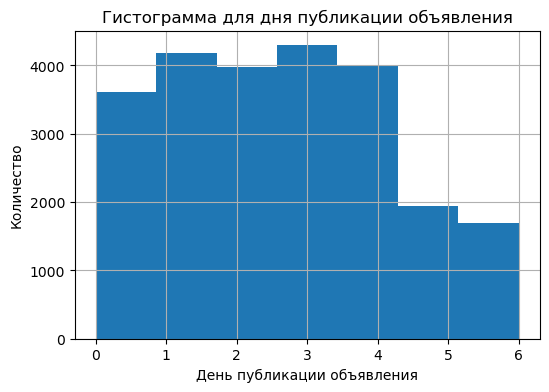

In [56]:
# Гистограмма день публикации объявления
data['day_first_exposition'].hist(bins=7, figsize=(6,4))
plt.title('Гистограмма для дня публикации объявления')
plt.xlabel('День публикации объявления')
plt.ylabel('Количество');

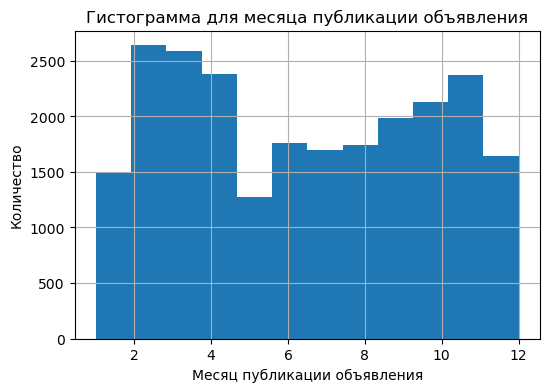

In [57]:
# Гистограмма месяц публикации объявления
data['month_first_exposition'].hist(bins=12, figsize=(6,4))
plt.title('Гистограмма для месяца публикации объявления')
plt.xlabel('Месяц публикации объявления')
plt.ylabel('Количество');

**Наблюдения по гистограммам параметров объектов**
- Среднее значение на гистограммах площади кухни, жилой площади, общей площади локализовано слева от центра размаха. Это связано с ограничением в 0 и не возможностью отрицательных значений.
- Цены объекта распределены номально, если на гистограмме отсечь значения свыше 30 млн. руб, которых не большое количество.
- Среднее значение на гистограмме этажа квартиры смещено влево из-за ограничения по невозможности нулевого и отрицательного этажей.
- Большинство объектов не на первом и последнем этажах. Категория `другой` больше примерно в два раза, чем сумма категорий `первый` и `последний`. Квартир на последнем этаже предлагается к продаже немного больше, чем на первом.
- Распределение числа этажей в доме не соответствует нормальному. Есть пики количества объектов 4-5 этажей, 8-10 этажей - крупные; 16-18, 25 - меньше. Очевидно, статистика показывает застройку города в разное время сериями домов 5 этажей, 8-10 этажей и более современные серии зданий 16-25 этажей в спальных районах. 
- Данные расстояний до центра города также имеют ряд пиков на гистограмме: 5 км, 15 км, небольшие пики 30, 40, 50 км. Эти локальные максимумы можно объяснить распределением объектов в городах и поселках вдоль крупных магистралей, например КАД = 15-20 км от центра города, трасса А-120, примерно 50 км. Либо просто расстоянием до крупных областных центров, где много предолжений квартир, например Шлиссельбург - примерно 40 км от центра города, Тосно - примерно 50 км.
- На гистограмме расстояния до ближайшего аэропорта имеется смещение влево из-за естественного ограничения на отрицательные значения.
- Аналогично с распределением расстояния до ближайшего парка.
- По гистограмме день `публикации объявления` можно сделать вывод о том, что в выходные подается примерно вдвое меньше объявлений о продаже, чем в будние дни.
- По гистограграмме `месяц публикации объявления` видно, что пользователи более активны весной и оснью, менее активны в декабре, январе и мае, преположительно из-за долгих праздников, а также летом, в сезон отпусков.



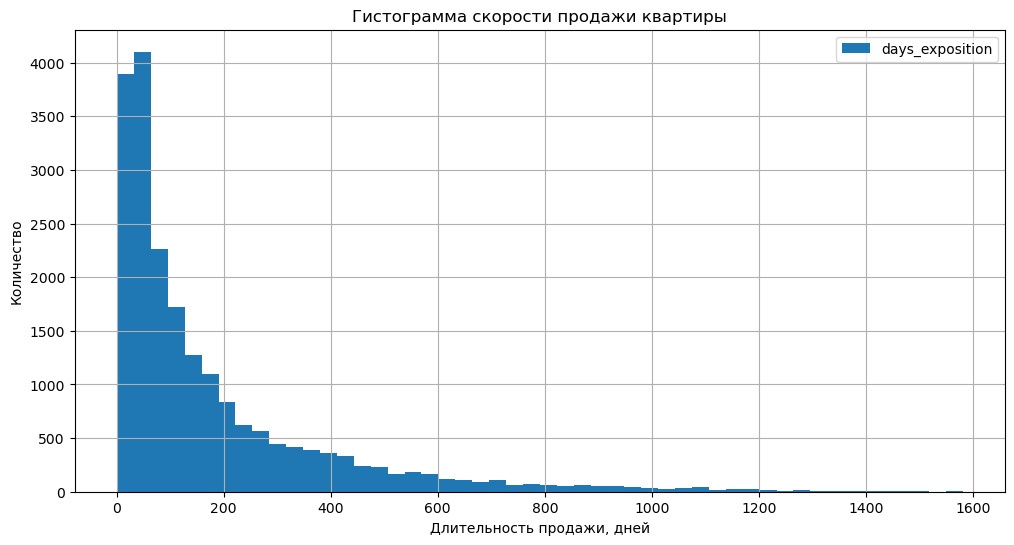

In [58]:
# Гистограмма скорости продажи квартиры (столбец days_exposition)
data['days_exposition'].hist(bins=50, figsize=(12,6), legend=True)
plt.title('Гистограмма скорости продажи квартиры')
plt.xlabel('Длительность продажи, дней')
plt.ylabel('Количество');

In [59]:
# Расчет медианы и среднего значения скорости продажи квартиры 
data['days_exposition'].describe()

count    20509.000000
mean       180.877761
std        219.746014
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

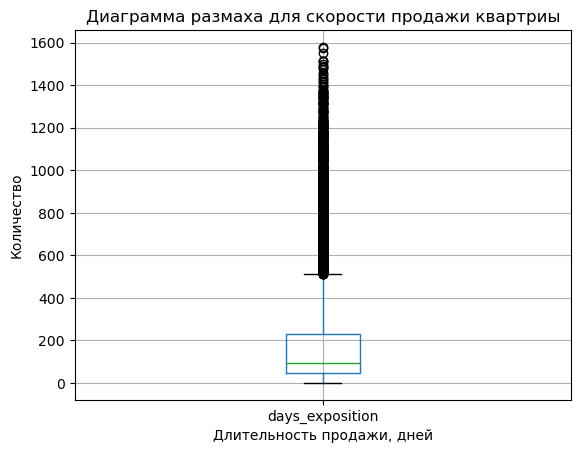

In [60]:
# Построение диаграммы "Ящик с усами"
data.boxplot(column='days_exposition')
plt.title('Диаграмма размаха для скорости продажи квартриы')
plt.xlabel('Длительность продажи, дней')
plt.ylabel('Количество');
plt.show();

Распределение дней продажи объекта ограничено слева отсутствием отрицательных значений. Медианное значение сильно отличается от среднего, что указывает на наличие выбросов в данных. Межквартильный размах равен 232-45 = 187. Полтора межквартильных размаха примерно 281. Тогда нормальные значения должны попадать в диапазон от 1 (минимальное значение) до 232+187= 513. Таким образом можно считать быстрыми продажи за менее 45 дней, долгие продажи более 232 дней, а необычно долгими продажи более 513 дней.

In [61]:
# Коэффициент корреляции Пирсона (для "типа этажа" не делаем расчет, т.к. не числовые значения)
list_corr = ['total_area','living_area', 'kitchen_area', 'rooms', 'day_first_exposition', 'month_first_exposition', 'year_first_exposition']
print('Коэффициент корреляции Пирсона значений last_price c:')
for a in list_corr:
    print(a, (data['last_price'].corr(data[a])))


Коэффициент корреляции Пирсона значений last_price c:
total_area 0.6538324908024701
living_area 0.5569095537117313
kitchen_area 0.44091582086709036
rooms 0.3634615671537363
day_first_exposition 0.002212462876671963
month_first_exposition 0.0026915905117614078
year_first_exposition -0.043063477062951966


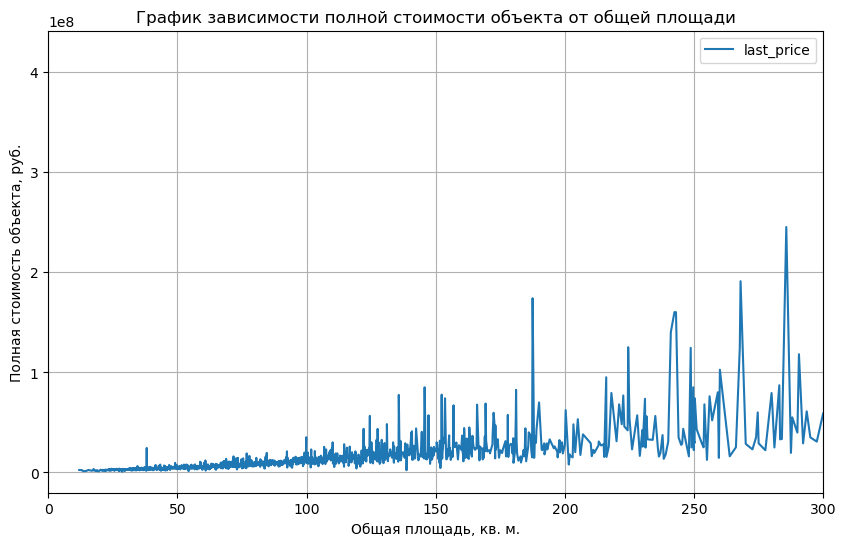

In [62]:
# График зависимости полной стоимости объекта от общей площади
(data
    .pivot_table(index='total_area', values='last_price')
    .plot(grid=True, figsize=(10, 6), xlim=(0, 300))
)
plt.title('График зависимости полной стоимости объекта от общей площади')
plt.xlabel('Общая площадь, кв. м.')
plt.ylabel('Полная стоимость объекта, руб.');
plt.show();

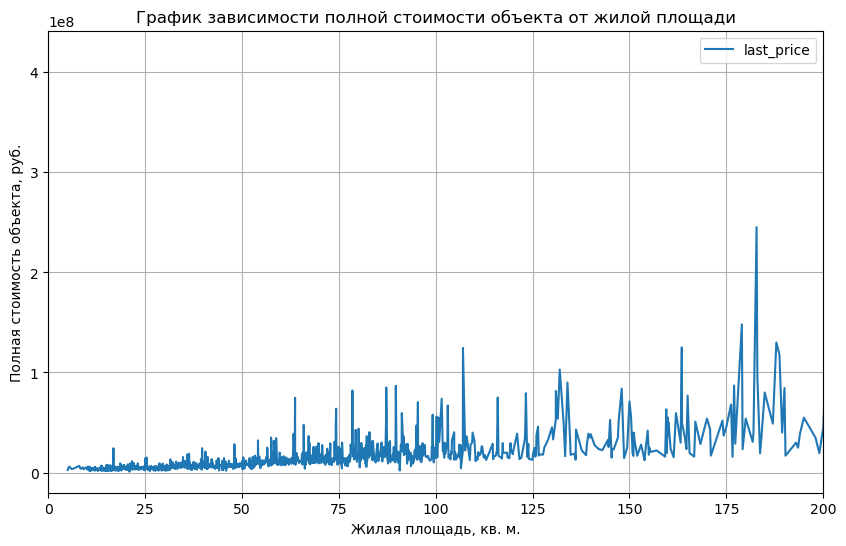

In [63]:
# График зависимости полной стоимости объекта от жилой площади
(data
     .pivot_table(index='living_area', values='last_price')
     .plot(grid=True, figsize=(10, 6), xlim=(0, 200))
)
plt.title('График зависимости полной стоимости объекта от жилой площади')
plt.xlabel('Жилая площадь, кв. м.')
plt.ylabel('Полная стоимость объекта, руб.');
plt.show();

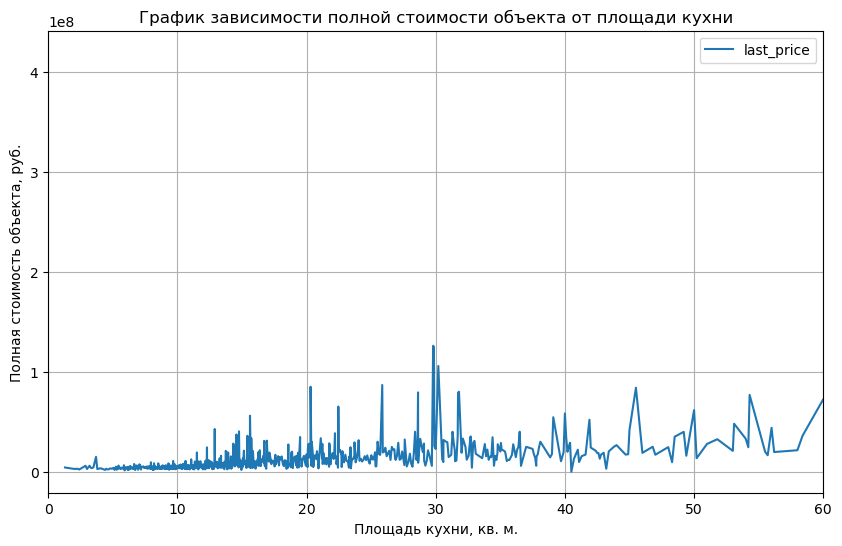

In [64]:
# График зависимости полной стоимости объекта от площади кухни
(data
     .pivot_table(index='kitchen_area', values='last_price')
     .plot(grid=True, figsize=(10,6), xlim=(0, 60))
)
plt.title('График зависимости полной стоимости объекта от площади кухни')
plt.xlabel('Площадь кухни, кв. м.')
plt.ylabel('Полная стоимость объекта, руб.');
plt.show();

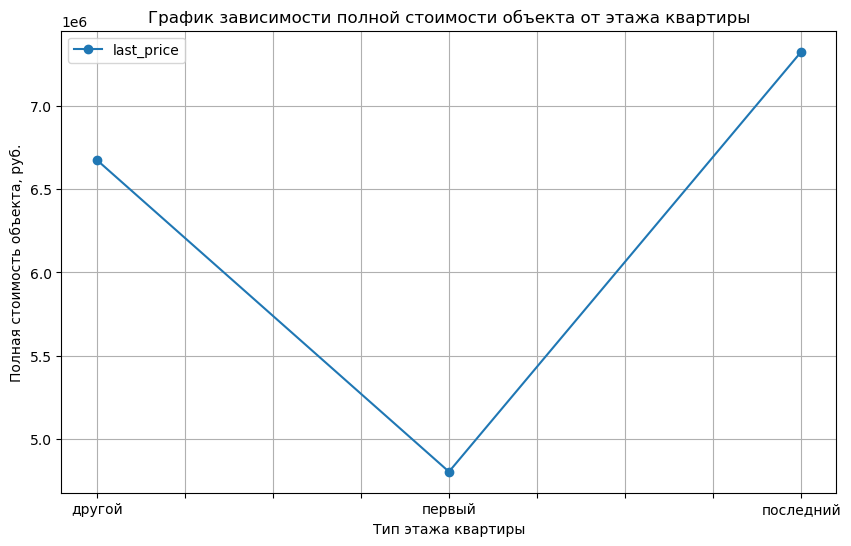

In [65]:
# График зависимости полной стоимости объекта от этажа, на котором расположена квартира
(data
     .pivot_table(index='floor_type', values='last_price')
     .plot(grid=True, figsize=(10,6), style='o-')
)
plt.title('График зависимости полной стоимости объекта от этажа квартиры')
plt.xlabel('Тип этажа квартиры')
plt.ylabel('Полная стоимость объекта, руб.');
plt.show();

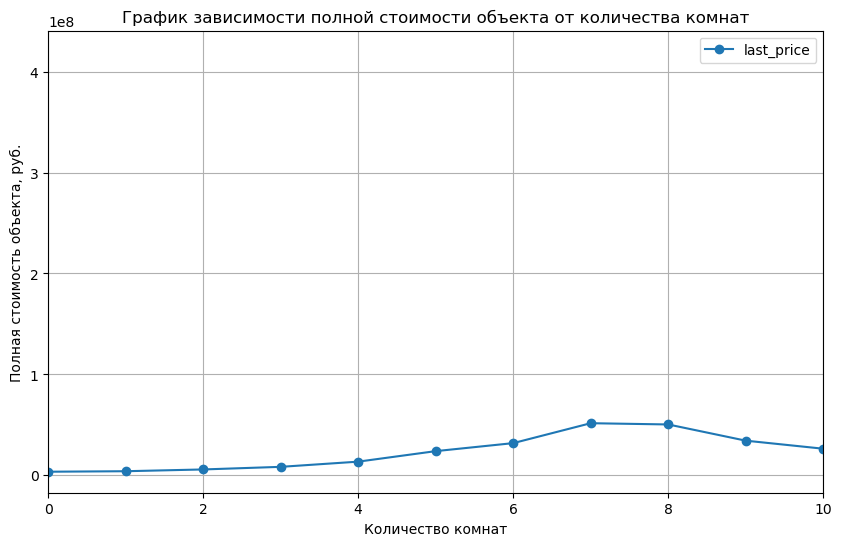

In [66]:
# График зависимости полной стоимости объекта от количества комнат
(data
    .pivot_table(index='rooms', values='last_price')
    .plot(grid=True, figsize=(10, 6), style='o-', xlim=(0, 10))
)
plt.title('График зависимости полной стоимости объекта от количества комнат')
plt.xlabel('Количество комнат')
plt.ylabel('Полная стоимость объекта, руб.');
plt.show();

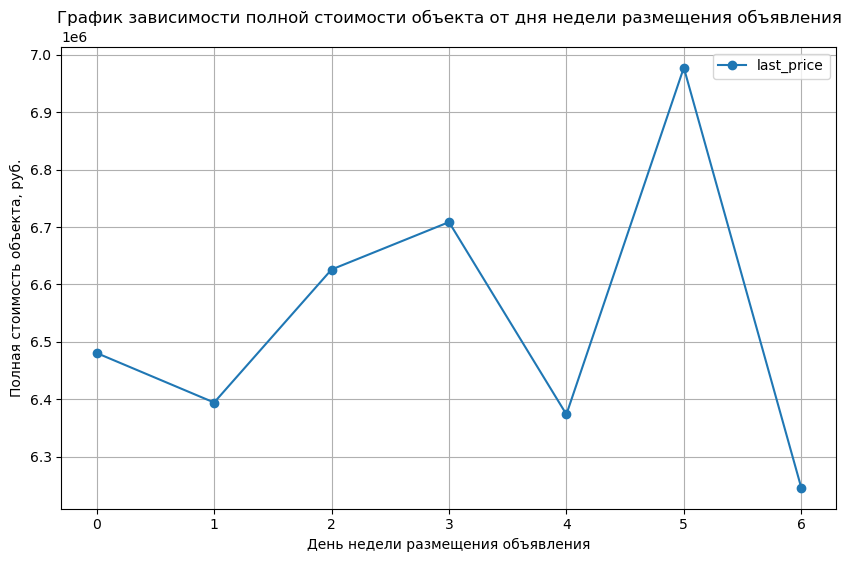

In [67]:
# График зависимости полной стоимости объекта от дня недели размещения объявления
(data
    .pivot_table(index='day_first_exposition', values='last_price')
    .plot(grid=True, figsize=(10, 6), style='o-')
)
plt.title('График зависимости полной стоимости объекта от дня недели размещения объявления')
plt.xlabel('День недели размещения объявления')
plt.ylabel('Полная стоимость объекта, руб.');
plt.show();

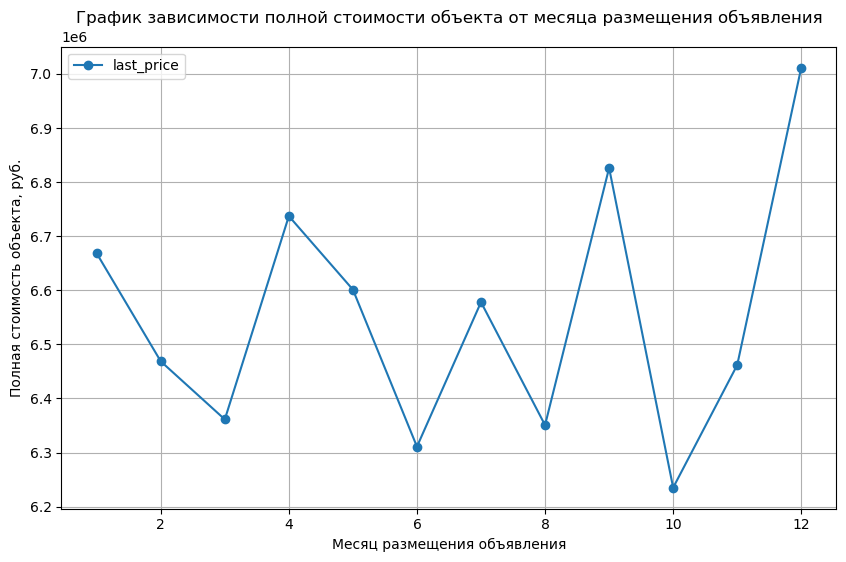

In [68]:
# График зависимости полной стоимости объекта от месяца размещения объявления
(data
 .pivot_table(index='month_first_exposition', values='last_price')
 .plot(grid=True, figsize=(10, 6), style='o-')

)
plt.title('График зависимости полной стоимости объекта от месяца размещения объявления')
plt.xlabel('Месяц размещения объявления')
plt.ylabel('Полная стоимость объекта, руб.');
plt.show();

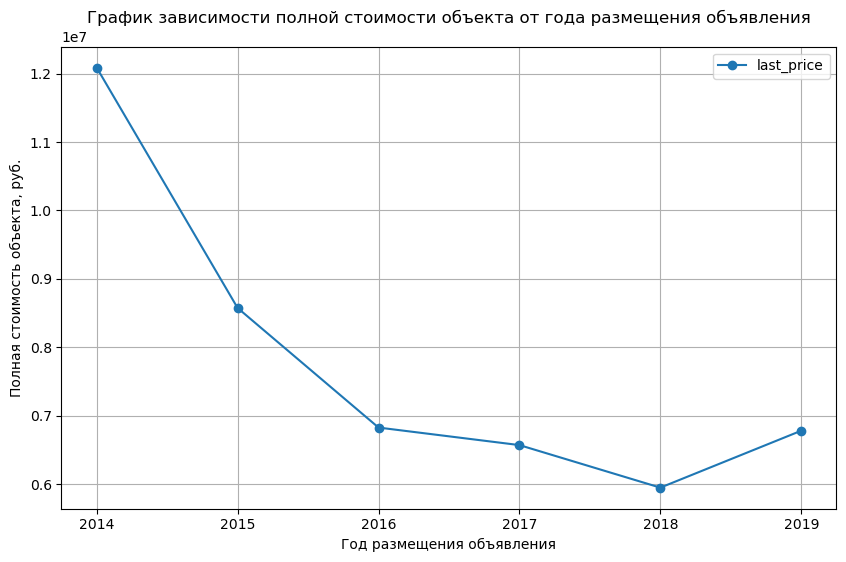

In [69]:
# График зависимости полной стоимости объекта от года размещения объявления
(data
    .pivot_table(index='year_first_exposition', values='last_price')
    .plot(grid=True, figsize=(10, 6), style='o-')
)
plt.title('График зависимости полной стоимости объекта от года размещения объявления')
plt.xlabel('Год размещения объявления')
plt.ylabel('Полная стоимость объекта, руб.');
plt.show();

**Факторы, влияющие на полную стоимость объекта**
- С ростом общей площади объекта, жилой площади, площади кухни в целом растет общая стоимость объекта. На больших значениях величин меньшее количество объектов, поэтому появляется много выбросов по цене вниз и вверх. Возможно, на стоимость таких эксклюзивных объектов влияют другие факторы, например, дизайнерские решения. Или имеют место ошибки во введенных пользователем данных. Наличие устойчивой связи подтверждается расчетом коэффициента Пирсона.
- Стоимость объектов на первом этаже значительно ниже, чем на других этажах. Стоимость квартир на последнем этаже несколько выше, чем стоимость квартир на этажах выше первого.
- С ростом числа комнат стоимость объектов растет примерно до 7 комнат. Начиная с 8 комнат стоимость несколько снижается. Для объектов с числом комнат более 10 стоимость больше зависит от других факторов, также сложно сделать выводы из-за меньшего числа таких объектов. Наличие устойчивой связи подтверждается расчетом коэффициента Пирсона.
- В понедельник, вторник, пятницу и воскресенье публикуются объявления с меньшей стоимостью объектов, чем в среду, четверг и субботу. Самые дорогие объявления публикуются в субботу, с самой низкой ценой - в воскресенье.
- Средняя стоимость объектов снижалась с 2014 по 2018 год. С 2018 по 2019 года наметился рост.


Корреляционные зависимости


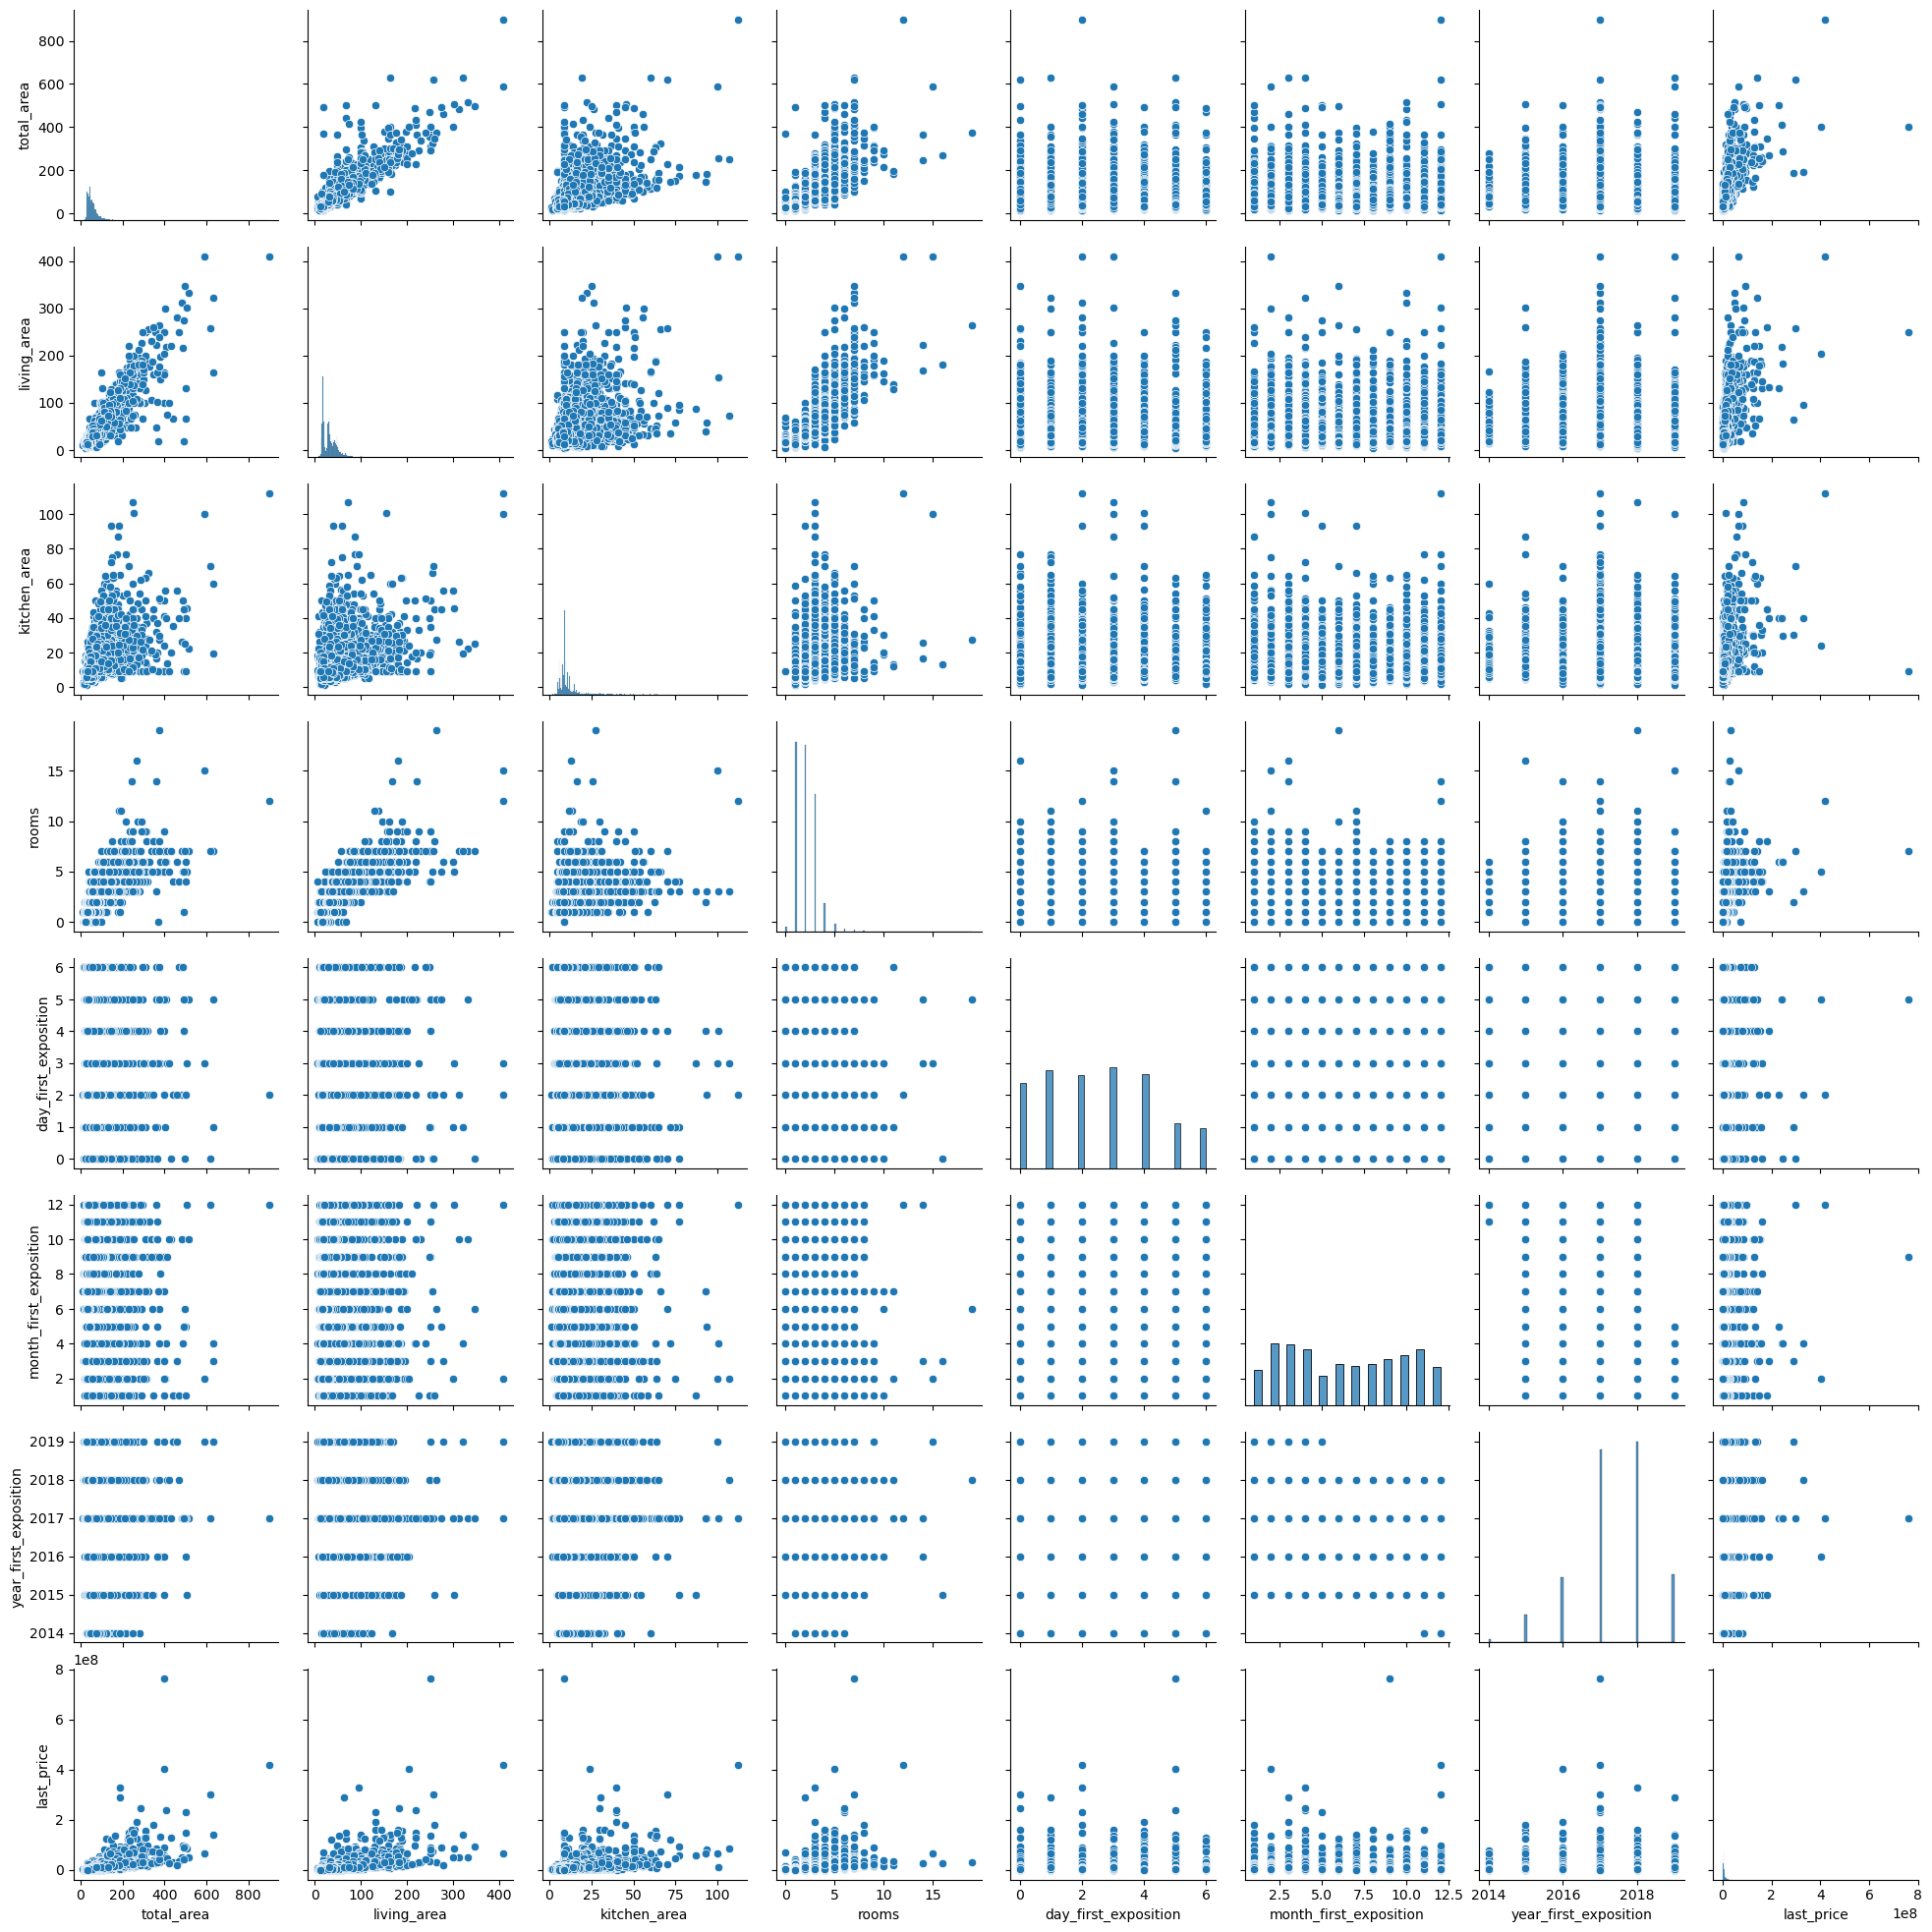

In [70]:
print('Корреляционные зависимости')
data_pairplot = data[['total_area', 'living_area', 'kitchen_area', 'floor_type', 'rooms', 'day_first_exposition', 
                      'month_first_exposition', 'year_first_exposition', 'last_price']]
sbn.pairplot(data_pairplot)
plt.show();

In [71]:
# Расчет средней стоимости 1 кв. метра для 10 населенных пунктов с наибольшим числом объявлений.
data_pivot_locality_cost = data.pivot_table(index='locality_name', values='sq_meter_cost', aggfunc=('mean', 'count'))
data_pivot_locality_cost = data_pivot_locality_cost.sort_values(by='count', ascending=False)
data_pivot_locality_cost.columns = ['number_of_locations', 'mean_sq_meter_cost']
data_pivot_locality_cost.reset_index(inplace=True)
print('Средняя стоимость 1 кв. метра в десяти локациях с наибольшим числом объявлений')
data_pivot_locality_cost.head(10)

Средняя стоимость 1 кв. метра в десяти локациях с наибольшим числом объявлений


,locality_name,number_of_locations,mean_sq_meter_cost
0,Санкт-Петербург,15713,114790.902149
1,поселок Мурино,590,86087.512050
2,деревня Кудрово,472,95324.930544
3,поселок Шушары,440,78677.364217
4,Всеволожск,398,68654.473986
5,Пушкин,369,103125.819291
6,Колпино,338,75424.579098
7,поселок Парголово,327,90175.913458
8,Гатчина,307,68746.146763
9,Выборг,237,58141.909153


In [72]:
# Населенные пункты с максимальной и минимальной стоимостью квадратного метра.
print('Населенный пункт с максимальной стоимостью квадратного метра:')
display(data_pivot_locality_cost.query('mean_sq_meter_cost == mean_sq_meter_cost.max()'))
print()
display(data_pivot_locality_cost.query('mean_sq_meter_cost == mean_sq_meter_cost.min()'))

Населенный пункт с максимальной стоимостью квадратного метра:


,locality_name,number_of_locations,mean_sq_meter_cost
47,Зеленогорск,24,115122.799198


,locality_name,number_of_locations,mean_sq_meter_cost
183,деревня Старополье,3,11206.221198


In [73]:
# Расчет средней стоимости кв. метра в Санкт-Петербурге в зависимость от расстояния до центра города
data_spb_center = data.query('(locality_name == "Санкт-Петербург") and (cityCenters_nearest_km.isna() != True)')
display(data_spb_center.pivot_table(index='cityCenters_nearest_km', values='sq_meter_cost'))

,sq_meter_cost
cityCenters_nearest_km,
0.0,245833.530289
1.0,177005.407676
2.0,157849.007329
3.0,121387.453704
4.0,133282.874761
5.0,140509.789046
6.0,150228.861102
7.0,156176.879664
8.0,124875.589458


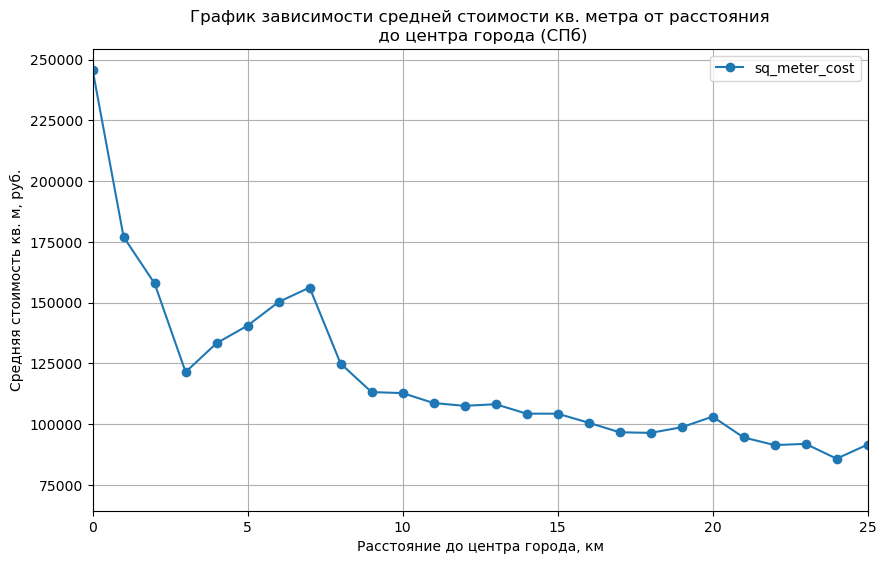

In [74]:
# График зависимости среденей стоимости кв. метра от расстояния до центра города в Сакнт-Петербурге
(data_spb_center
    .pivot_table(index='cityCenters_nearest_km', values='sq_meter_cost')
    .plot(grid=True, figsize=(10, 6), style='o-', xlim=(0, 25))
)
plt.title('График зависимости средней стоимости кв. метра от расстояния\n до центра города (СПб)')
plt.xlabel('Расстояние до центра города, км')
plt.ylabel('Средняя стоимость кв. м, руб.');
plt.show();

Стоимость объектов снижается с ростом расстояния от центра города. Есть локальные максимумы в районе 6-7, 20 км, предположительно связанные с доступностью объектов, расположенных на магистралях КАД и ЗСД. Значения свыше 25 км возможно связаны с ошибками в данных, судя по расстоянию находятся за городской чертой.

### Общий вывод

В результате проведенного исследования можно сделать следующие выводы:
- в предоставленных для анализа исходных данных есть значительное количество пропущенных значений в столбце `is_apartment` и, что особенно важно, в столбцах `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `parks_around3000`, `parks_around3000`. [Пример сток](#example). Разработчикам необходимо проверить алгоритмы расчета координат и выгрузки данных.
- Площадь квартиры является основным фактором, определяющим ее стоимость, с ростом площади стоимость увеличивается. Квартиры на первом этаже предлагаются к продаже по меньшей цене. Стоимость объектов снижается с ростом расстояния от центра города. С 2014 по 2018 года наблюдалось снижение средней стоимости жилой недвижимости, с 2018 по 2019 наметился рост. 
- Пользователи более активны весной и осенью. Летом, предположительно из-за сезона отпусков наблюдается спад подачи объявлений о продаже квартир, также активность меньше в мае, декабре и январе, скорее всего из-за долгих праздников.
- Типичное время продажи с момента подачи объявления составляет 95 дней, быстрые продажи менее 45 дней, долгие - более 232 дней, экстермально долгие - более 513 дней.